<a href="https://colab.research.google.com/github/diego-mogollon/lateguru/blob/conor-data-modelling/Lateguru_Modelling_C_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries & Datasets**

This notebook models flight delays using binary classification with two models:
- A dense neural network with a sigmoid activation function
- A Bagged Classifier of Random Forest Base Models

In [1]:
#importing python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA

#import xgboost as xgb

#from imblearn.over_sampling import SMOTE, ADASYN


In [2]:
from google.colab import drive


# Mount your Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:


# Specify the path to your CSV file (replace with your actual path)
X_test_preprocessed = '/content/drive/MyDrive/Lateguru/data/X_test_preprocessed_dt.csv'
X_train_preprocessed = '/content/drive/MyDrive/Lateguru/data/X_train_preprocessed_dt.csv'
y_test_sample = '/content/drive/MyDrive/Lateguru/data/y_test_sample_dt.csv'
y_train_sample = '/content/drive/MyDrive/Lateguru/data/y_train_sample_dt.csv'

# Specify the path to your CSV file (replace with your actual path)
# - Lighter csvs with smaller dimensionality
'''X_test_preprocessed_lite = '/content/drive/MyDrive/Lateguru/data/X_test_preprocessed_dt_lite.csv'
X_train_preprocessed_lite = '/content/drive/MyDrive/Lateguru/data/X_train_balanced_dt_lite.csv'
y_test_sample_lite = '/content/drive/MyDrive/Lateguru/data/y_test_sample_dt_lite.csv'
y_train_sample_lite = '/content/drive/MyDrive/Lateguru/data/y_train_balanced_dt_lite.csv'''

'''# Read the CSV file into a Pandas DataFrame
X_test_preprocessed_df = pd.read_csv(X_test_preprocessed, compression='zip')
X_train_preprocessed_df = pd.read_csv(X_train_preprocessed,compression='zip')
y_test_sample_df = pd.read_csv(y_test_sample, compression='zip')
y_train_sample_df = pd.read_csv(y_train_sample, compression='zip')'''

# Read the CSV file into a Pandas DataFrame
X_test_preprocessed_df = pd.read_csv(X_test_preprocessed, compression='zip')
X_train_preprocessed_df = pd.read_csv(X_train_preprocessed,compression='zip')
y_test_sample_df = pd.read_csv(y_test_sample, compression='zip')
y_train_sample_df = pd.read_csv(y_train_sample, compression='zip')

# Print the first few rows of the DataFrame
print(X_test_preprocessed_df.head(1))
print(X_train_preprocessed_df.head(1))
print(y_test_sample_df.head(1))
print(y_train_sample_df.head(1))

     0    1    2    3    4    5    6    7    8    9  ...       411       412  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.343952 -0.392953   

        413       414       415     416       417       418       419  \
0  0.418822 -1.065777 -0.428486 -0.1986 -0.010991 -1.336718  1.011177   

        420  
0  0.098363  

[1 rows x 421 columns]
     0    1    2    3    4    5    6    7    8    9  ...       411       412  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.398641 -0.497578   

        413       414      415     416       417       418       419       420  
0  0.418822 -1.065777 -0.62108 -0.1986 -0.010991 -0.143549  0.010834  1.555977  

[1 rows x 421 columns]
   Delayed
0    False
   Delayed
0     True


In [4]:
y_test_sample_df.value_counts(normalize=True)

,proportion
Delayed,
False,0.610721
True,0.389279


In [5]:
y_train_sample_df.value_counts(normalize=True)

,proportion
Delayed,
False,0.61072
True,0.38928


In [ ]:
print(type(y_train_sample_arr))

<class 'numpy.ndarray'>


In [6]:
y_test_sample_df['Delayed'] = y_test_sample_df['Delayed'].apply(lambda x: 1 if x == True else 0)
y_train_sample_df['Delayed'] = y_train_sample_df['Delayed'].apply(lambda x: 1 if x == True else 0)

In [ ]:
#Using principal component analysis to reduce dimensionality
pca = PCA(n_components=7)
X_train_preprocessed_df = pca.fit_transform(X_train_preprocessed_df)
X_test_preprocessed_df = pca.transform(X_test_preprocessed_df)


In [28]:
X_test_preprocessed_arr = np.array(X_test_preprocessed_df)
X_train_preprocessed_arr = np.array(X_train_preprocessed_df)
y_test_sample_arr = np.array(y_test_sample_df)
y_train_sample_arr = np.array(y_train_sample_df)


In [29]:
print(f"X_test_preprocessed shape: {X_test_preprocessed_arr.shape}")
print(f"X_train_preprocessed shape: {X_train_preprocessed_arr.shape}")
print(f"y_test_sample shape: {y_test_sample_arr.shape}")
print(f"y_train_sample shape: {y_train_sample_arr.shape}")


X_test_preprocessed shape: (302891, 421)
X_train_preprocessed shape: (1211560, 421)
y_test_sample shape: (302891, 1)
y_train_sample shape: (1211560, 1)


In [ ]:
#y_train_sample_arr = y_train_sample_arr.reshape(-1)
#only needed with SVM, uncomment for NN


In [30]:
#splitting the test data into a validation set to ensure no data leakage during nn training
#make sure to evaluate the model on X_test_sample_nn

X_val, X_test_sample_nn, y_val, y_test_sample_nn = train_test_split(X_test_preprocessed_arr, y_test_sample_arr,
                 test_size=0.5,
                 random_state=42,
                 stratify=y_test_sample_arr)

In [ ]:
pd.DataFrame(y_val).value_counts(normalize=True)

,proportion
0,
False,0.610723
True,0.389277


In [ ]:
pd.DataFrame(y_test_sample_nn).value_counts(normalize=True)

,proportion
0,
False,0.610719
True,0.389281


In [31]:
print(f"X_val shape: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test_sample_nn shape: {X_test_sample_nn.shape}")
print(f"y_test_sample_nn: {y_test_sample_nn.shape}")

X_val shape: (151445, 421)
y_val: (151445, 1)
X_test_sample_nn shape: (151446, 421)
y_test_sample_nn: (151446, 1)


 #  **Modelling with a SVM Classifier**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score, f1_score, confusion_matrix



In [ ]:
sig_svm_clf = SVC(kernel='rbf')

In [ ]:
sig_svm_clf.fit(X_train_preprocessed_arr, y_train_sample_arr)

In [ ]:
y_pred = sig_svm_clf.predict(X_test_preprocessed)

In [ ]:
recall = recall_score(y_test_sample, y_pred)
print(f"Recall: {recall}")

f1 = f1_score(y_test_sample, y_pred)
print(f"F1 score: {f1}")

# **Modelling with Neural Networks**

## Dense Neural Net

In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop


# Assuming you have your input data prepared


model = Sequential()
model.add(layers.Dense(128,activation='tanh', input_dim=X_train_preprocessed_arr.shape[1]))
#model.add(layers.Conv1D(128,activation='relu'))
#model.add(layers.Conv1D(64,2,activation='relu'))
#model.add(layers.Dense(128,activation='relu'))
#model.add(layers.Dense(128,activation='tanh'))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(32,activation='tanh')) #regularise some layers, try tanh a bit
#model.add(layers.Dense(16,activation='tanh'))
model.add(layers.Dense(8,activation='tanh'))
model.add(layers.Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 128)                 │          54,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,625 (252.44 KB)

 Trainable params: 64,625 (252.44 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = Adam(
    learning_rate=0.001
)

RMSprop = RMSprop(
    learning_rate=0.001
)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', 'recall', 'precision', 'f1_score'])


#optimise learning rates by splitting out adam

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=20, restore_best_weights=True)

In [ ]:
#Need to manually define a balanced validation set

In [ ]:
history = model.fit(X_train_preprocessed_arr, y_train_sample_arr, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks =[es])

Epoch 1/10
37862/37862 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 0.4488 - recall: 0.5309 - val_loss: 0.4384 - val_recall: 0.5370
Epoch 2/10
37862/37862 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.4386 - recall: 0.5430 - val_loss: 0.4359 - val_recall: 0.5450
Epoch 3/10
37862/37862 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.4361 - recall: 0.5474 - val_loss: 0.4344 - val_recall: 0.5482
Epoch 4/10
37862/37862 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - loss: 0.4336 - recall: 0.5520 - val_loss: 0.4341 - val_recall: 0.5568
Epoch 5/10
37862/37862 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.4330 - recall: 0.5541 - val_loss: 0.4331 - val_recall: 0.5515
Epoch 6/10
30320/37862 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.4314 - recall: 0.5555

KeyboardInterrupt: 

## Ann Neural Network

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Recall, Precision

def create_ann(input_shape):
    model = Sequential()

    model.add(Dense(128, input_shape=(input_shape,), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall(), Precision()])

    return model

ann_model = create_ann(X_train_preprocessed_arr.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=20, restore_best_weights=True)

In [33]:
ann_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │          54,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,113 (477.00 KB)

 Trainable params: 121,089 (473.00 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [37]:
history = ann_model.fit(X_train_preprocessed_arr, y_train_sample_arr, epochs=50, batch_size=256, validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/50
4733/4733 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7784 - loss: 0.4790 - precision_2: 0.8580 - recall_2: 0.5206 - val_accuracy: 0.7967 - val_loss: 0.4375 - val_precision_2: 0.9094 - val_recall_2: 0.5306
Epoch 2/50
4733/4733 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7942 - loss: 0.4425 - precision_2: 0.8951 - recall_2: 0.5340 - val_accuracy: 0.7981 - val_loss: 0.4348 - val_precision_2: 0.8908 - val_recall_2: 0.5485
Epoch 3/50
4733/4733 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7955 - loss: 0.4392 - precision_2: 0.8917 - recall_2: 0.5393 - val_accuracy: 0.7983 - val_loss: 0.4333 - val_precision_2: 0.8862 - val_recall_2: 0.5528
Epoch 4/50
4733/4733 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7963 - loss: 0.4374 - precision_2: 0.8894 - recall_2: 0.5451 - val_accuracy: 0.7985 - val_loss: 0.4322 - val_precision_2: 0.9007 - val_recall_2: 0.5423
Epoch 5/50
4733/4733 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7961 - loss: 0.4367 - precision_2: 0.8906 - rec

In [16]:
history.history

{'accuracy': [0.788326621055603,
  0.7933975458145142,
  0.7946676015853882,
  0.7952216267585754,
  0.7958768010139465,
  0.796166718006134,
  0.7963390350341797,
  0.7968136072158813,
  0.7968817353248596,
  0.7972995638847351,
  0.7975719571113586,
  0.7974997162818909,
  0.797500729560852,
  0.7977731227874756,
  0.7977101802825928,
  0.7980496287345886,
  0.7981992363929749,
  0.7986387610435486,
  0.7984520196914673,
  0.7986067533493042,
  0.798503577709198,
  0.7987769842147827,
  0.7987769842147827,
  0.7988605499267578,
  0.7989152669906616,
  0.7991896867752075,
  0.7992454171180725,
  0.7991793751716614,
  0.7993392944335938,
  0.7994145750999451,
  0.7994610071182251,
  0.7994630932807922,
  0.7996591329574585,
  0.7995538711547852,
  0.7994073629379272,
  0.7997695207595825,
  0.7997901439666748,
  0.7996158003807068,
  0.7998902201652527,
  0.8000233173370361,
  0.8001161813735962,
  0.7999696731567383,
  0.8003947138786316,
  0.7998159527778625,
  0.8000666499137878,
  

In [20]:
loss, accuracy, recall, precision = ann_model.evaluate(X_test_sample_nn, y_test_sample_nn)

print(f"Test loss:{loss}")
print(f"Test recall:{recall}")
print(f"Test accuracy:{accuracy}")
print(f"Test precision:{precision}")
#print(f"Test f1 score:{f1_score}")

4733/4733 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7974 - loss: 0.4350 - precision: 0.8994 - recall: 0.5428
Test loss:0.4343278110027313
Test recall:0.5424985289573669
Test accuracy:0.7981260418891907
Test precision:0.8988028168678284


NameError: name 'f1_score' is not defined

In [22]:
y_pred = ann_model.predict(X_test_sample_nn)

4733/4733 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


In [ ]:
y_test_sample_nn

In [ ]:
y_test_sample_nn

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [23]:
y_pred

array([[0.99932724],
       [0.2704296 ],
       [0.99999917],
       ...,
       [0.99995315],
       [0.25191122],
       [0.1013118 ]], dtype=float32)

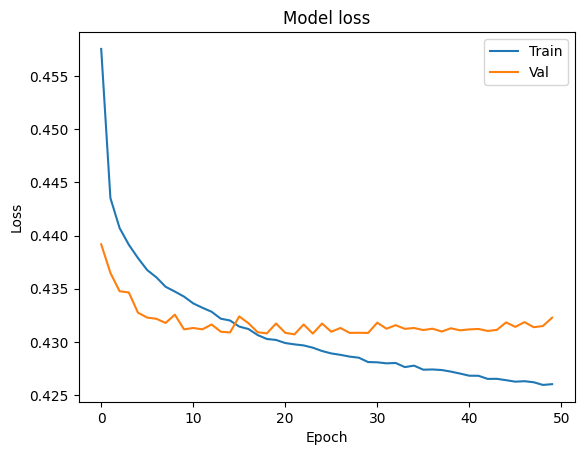

In [24]:
#visualise  graph for overfitting using history

import matplotlib.pyplot as plt

# Assuming you have a history object from model.fit()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()




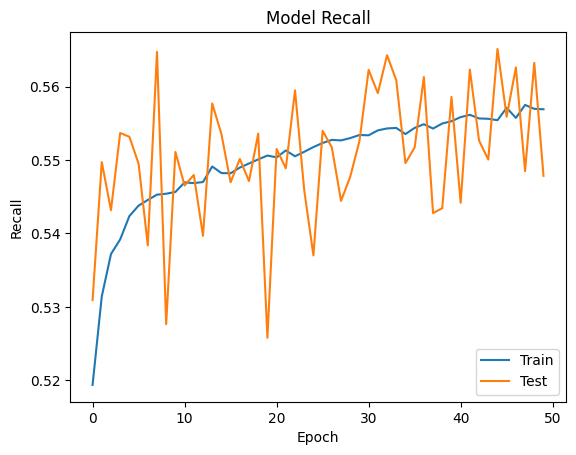

In [25]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# **Bagged Random Forest Model**

In [ ]:
# Create base Random Forest model
base_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create bagged ensemble
bagged_model = BaggingClassifier(estimator=base_model, n_estimators=10, random_state=42)

In [ ]:
# Fit the model
bagged_model.fit(X_train_preprocessed_arr, y_train_sample_arr)



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Make predictions
y_pred = bagged_model.predict(X_test_preprocessed_arr)

In [ ]:
y_pred

In [ ]:
y_test_sample_arr = y_test_sample_arr.reshape(-1)

In [ ]:
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score, f1_score, confusion_matrix, precision_score, precision_recall_curve

recall = recall_score(y_test_sample_arr, y_pred)
print(f"Recall: {recall}")

f1 = f1_score(y_test_sample_arr, y_pred)
print(f"F1 score: {f1}")

roc_auc = roc_auc_score(y_test_sample_arr, y_pred)
print(f"Roc-auc score: {roc_auc}")

accuracy = accuracy_score(y_test_sample_arr, y_pred)
print(f"accuracy score: {accuracy}")

precision = precision_score(y_test_sample_arr, y_pred)
print(f"precision score: {precision}")

In [ ]:
cm = confusion_matrix(y_test_sample_arr, y_pred)
print(f"Confusion Matrix:\n{cm}")

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test_sample_arr, y_pred)
print(f"Classification Report:\n{report}")

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test_sample_arr, y_pred)

In [ ]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_sample_arr, y_pred)

In [ ]:
average_precision

In [ ]:
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.ylim([0.0, 1.05])
#plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))


plt.show()